In [10]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line
from math import sin,cos,pi

# Problem 1

(400, 680, 3)


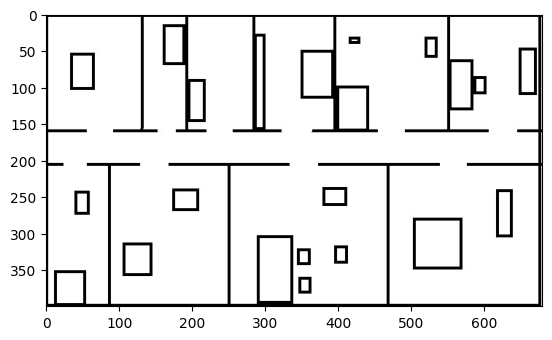

In [11]:
map=cv2.imread('./Map.jpg')
map=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
print(map.shape)
plt.imshow(map)

In [60]:
def draw_rays(x,y,theta,max_measurement=1200,map=map,opening_angle=250,step=2):
    distances=[]
    modified_map=map.copy()
    max_measurement = max_measurement//4
    cv2.circle(modified_map,(x,y),4,(255,0,0),thickness=4)
    for i in range(-opening_angle//2,(opening_angle//2)+1,step):
        end_x = int(x + max_measurement * np.cos(np.radians(theta + i)))
        end_y = int(y + max_measurement * np.sin(np.radians(theta + i)))
        #draw line
        pixelx,pixely=line(x,y,end_x,end_y)
        for index_x,index_y in zip(pixelx,pixely):
            if index_x>=0 and index_x<modified_map.shape[1] and index_y>=0 and index_y<modified_map.shape[0]:
                if np.array_equal(modified_map[index_y, index_x], [0, 0, 0]):
                    end_x=index_x
                    end_y=index_y
                    break
        
        cv2.line(modified_map,(x,y),(end_x,end_y),(0,255,0),1)
        distances.append(np.sqrt((end_x-x)**2+(end_y-y)**2))   
    return modified_map,distances


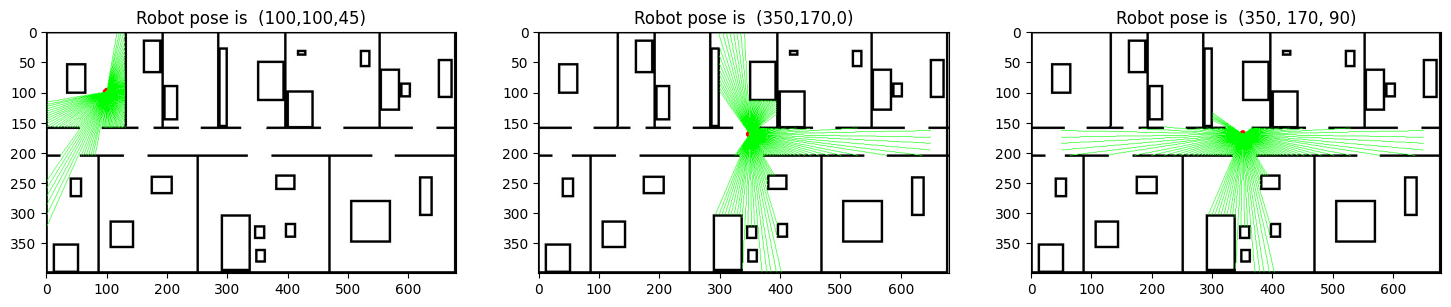

In [80]:
map=cv2.imread('./Map.jpg')
testcase1,_ = draw_rays(100, 100, 45, max_measurement=1200,map=map,opening_angle=250,step=2)
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

axes[0].set_title(f'Robot pose is  (100,100,45)')
axes[0].imshow(testcase1)
testcase2,_ = draw_rays(350, 170, 0, map=map)
axes[1].set_title(f'Robot pose is  (350,170,0)')
axes[1].imshow(testcase2)
testcase3,_=draw_rays(350, 170, 90, map=map)
axes[2].set_title(f'Robot pose is  (350, 170, 90)')
axes[2].imshow(testcase3)

plt.show()

# Problem 2

In [81]:
def read_map_construct_likelihood_map(image_path):
    map=cv2.imread(image_path)
    _, map = cv2.threshold(cv2.cvtColor(map, cv2.COLOR_RGB2GRAY), 128, 1, cv2.THRESH_BINARY)
    likelihood_field=1-map
    blurred_likelihood=cv2.GaussianBlur(likelihood_field,(3,3),0)
    preventing_zero_propabiliy_map=(blurred_likelihood+0.0001)
    normalized_map=preventing_zero_propabiliy_map/preventing_zero_propabiliy_map.max()
    return normalized_map

In [114]:
def find_robot_pose(image_path, distances):
    map=read_map_construct_likelihood_map(image_path)
    position_x = 0
    position_y = 0
    the_desired_orientation = 0
    max_theta_probability = 0
    max_probability = 0

    for y in range(0, map.shape[0], 5):
        for x in range(0, map.shape[1], 5):
            if map[y][x]==1.0:
                continue
            all_theta_probablities = []
            theta_wanted=[]
            for theta in range(0, 360, 10):
                index=0
                product=1.0
                for angle in range(theta-125,theta+125,2):
                    # vectorize the code
                    end_x = ((x + distances[index] * np.cos(np.radians(angle)))).astype(
                        int
                    )
                    end_y = ((y + distances[index] * np.sin(np.radians(angle)))).astype(
                        int
                    )
                    if end_x>=map.shape[1] or end_y>=map.shape[0]:
                            product*=0.00001
                    else:
                        product*=map[end_y,end_x] 
                    index+=1
                all_theta_probablities.append(product)
                theta_wanted.append(theta)
                
            max_theta_probability = max(all_theta_probablities)
            orientation= np.argmax(all_theta_probablities)
            orientation=theta_wanted[orientation]


            # Update global max probability and orientation
            if max_theta_probability > max_probability:
                max_probability = max_theta_probability
                position_x, position_y = x, y
                the_desired_orientation = orientation
                print(position_x, position_y, the_desired_orientation,max_probability)
            
            map[y, x] = max_theta_probability
    final_likelihood = np.zeros((map.shape[0], map.shape[1]))
    final_likelihood[position_y, position_x] = 255
    print(f"Position: ({position_x}, {position_y}), Orientation: {the_desired_orientation} with max probability: {max_probability}")

    return final_likelihood


In [115]:

def displaying_robot_position(likelihood_map):
    circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9 ,9))
    dilated_image = cv2.dilate(likelihood_map, circle_kernel)
    y,x=np.unravel_index(np.argmax(likelihood_map),likelihood_map.shape)
    plt.title("right pose is (100, 55, 40)")
    plt.imshow(dilated_image,cmap='gray')

30 5 30 9.92329951078906e-309
100 10 40 9.924291840740138e-305
10 30 310 9.929254979188937e-285
40 30 310 9.930247904686855e-281
245 30 310 9.943164975397067e-229
100 55 40 9.968052740212335e-129
Position: (100, 55), Orientation: 40 with max probability: 9.968052740212335e-129


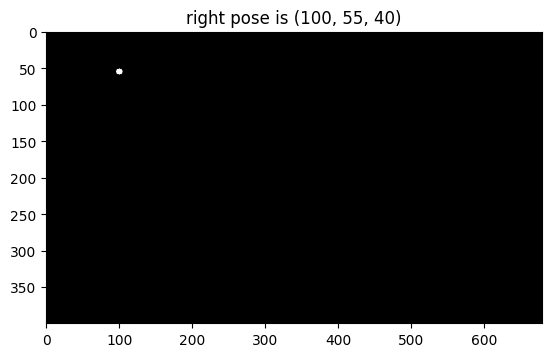

In [116]:
image_path='Map.jpg'
map,distances=draw_rays(100, 55, 40, map=map)
likelihood = find_robot_pose(image_path, distances)
image=displaying_robot_position(likelihood)
